## Assignment 01: Cluster analysis on gene expression data

### 1. Data Download and Preprocessing

In [24]:
# library
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
from sklearn import cluster
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.metrics import normalized_mutual_info_score as nmi

In [12]:
# download the data
# tpm data
tpm_url = "https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
tpm_file_path = "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
tpm_cmd = f"curl --output {tpm_file_path} {tpm_url}"
os.system(tpm_cmd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1550M  100 1550M    0     0  20.2M      0  0:01:16  0:01:16 --:--:-- 20.3M


0

In [13]:
# metadata
meta_url = "https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"
meta_file_path = "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"
meta_cmd = f"curl --output {meta_file_path} {meta_url}"
os.system(meta_cmd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.9M  100 10.9M    0     0  13.5M      0 --:--:-- --:--:-- --:--:-- 13.5M


0

In [2]:
# load metadata files
metadata_df = pd.read_csv(
    "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", 
    sep='\t'
)
print(metadata_df[metadata_df.SAMPID == "GTEX-1117F-0003-SM-58Q7G"]['SMTS'])

0    Blood
Name: SMTS, dtype: object


In [3]:
# Load TPM data
tpm_lazy_df = pl.read_csv(
    source = "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz", 
    separator = "\t", 
    skip_rows = 2
) 

In [5]:
# Create a subset of the data we will work on
# - Use the metadata file to select the top 10 tissues with the largest sample size.
top_10_tissues = metadata_df.SMTS.value_counts().nlargest(10).reset_index()[['SMTS']].values.flatten()
print(f'Top ten tissues by sample size: \n  {top_10_tissues}')

# - only keep the columns for top 10 tissues
top_10_tissues_ids = np.unique(metadata_df[metadata_df.SMTS.isin(top_10_tissues)].SAMPID.values)
print(f"The ids for top 10 tissues are: {len(top_10_tissues_ids)}")
# - only get those IDs present in tpm count data
tpm_df_colums = np.array(tpm_lazy_df.columns)
top_10_tissues_ids = [ tissue_id for tissue_id in top_10_tissues_ids if tissue_id in tpm_df_colums]

print(f"The ids for top 10 tissues are and in tpm data: {len(top_10_tissues_ids)}")
top_10_tissues_ids.insert(0, "Name")
# only subset the data from top 10 tissues
top_10_tissues_subset = tpm_lazy_df.select(top_10_tissues_ids)
print(top_10_tissues_subset.shape)

Top ten tissues by sample size: 
  ['Blood' 'Brain' 'Skin' 'Esophagus' 'Blood Vessel' 'Adipose Tissue'
 'Heart' 'Muscle' 'Lung' 'Colon']
The ids for top 10 tissues are: 17163
The ids for top 10 tissues are and in tpm data: 12385
(56200, 12386)


In [6]:
# Use the bulk tissue expression file to select the top 5,000 most variable genes.
genes_vars = {}
for row_idx in tqdm(range(top_10_tissues_subset.shape[0])):
    row = top_10_tissues_subset.row(row_idx)
    gene_ensembl_id = row[0]
    # min max of the rows
    gene_exp = row[2:]
    normalized_gene_exp = (gene_exp - np.min(gene_exp)) / (np.max(gene_exp) - np.min(gene_exp))
    genes_vars[gene_ensembl_id] = np.var(row[2:])

  0%|                                        | 37/56200 [00:01<21:46, 42.98it/s]/var/folders/rd/c2tlh0qn3y7fvt1bwwd_d2x80000gn/T/ipykernel_47220/1486303560.py:8: RuntimeWarning: invalid value encountered in divide
  normalized_gene_exp = (gene_exp - np.min(gene_exp)) / (np.max(gene_exp) - np.min(gene_exp))
100%|████████████████████████████████████| 56200/56200 [04:15<00:00, 220.03it/s]


In [13]:
# get the top 5,000 most variables genes
from operator import itemgetter
topk = 5000
topk_genes = sorted(genes_vars.items(), key=itemgetter(1), reverse=True)[:topk]
most_variables_genes = [k[0] for k in topk_genes]
print(most_variables_genes[:10])

['ENSG00000244734.3', 'ENSG00000210082.2', 'ENSG00000198804.2', 'ENSG00000188536.12', 'ENSG00000198712.1', 'ENSG00000198938.2', 'ENSG00000198899.2', 'ENSG00000198886.2', 'ENSG00000163220.10', 'ENSG00000198888.2']


In [14]:
# subset the data by most variables genes
prepped_data = top_10_tissues_subset.filter(
    pl.col('Name').is_in(most_variables_genes)
).to_pandas()
prepped_data = prepped_data.reset_index(drop=True).set_index("Name").T
#prepped_data = prepped_data.T
prepped_data.shape

(12385, 5000)

In [15]:
prepped_data = prepped_data.reset_index().merge(
    metadata_df[['SAMPID', 'SMTS']], 
    left_on = "index", 
    right_on = "SAMPID"
).drop(['index', 'SAMPID'], axis = 1)
prepped_data['tissue'] = prepped_data.SMTS
prepped_data.drop(columns = ['SMTS'], axis = 1, inplace = True)
prepped_data.head()

,ENSG00000268903.1,ENSG00000269981.1,ENSG00000225972.1,ENSG00000225630.1,ENSG00000237973.1,ENSG00000229344.1,ENSG00000240409.1,ENSG00000248527.1,ENSG00000198744.5,ENSG00000188976.10,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2,tissue
0,3.2150,7.0120,8.532,359.0,27.950,11.680,22.81,1433.0,23.140,90.74,...,12400.0,0.0000,0.0000,2928.0,3799.0,16.240,6938.0,0.943,0.000,Adipose Tissue
1,0.2492,0.4969,31.870,650.7,68.360,30.210,74.21,5677.0,246.200,93.56,...,34030.0,0.0000,0.0000,10400.0,14750.0,44.310,26310.0,6.414,6.226,Muscle
2,1.3560,0.4806,13.210,281.0,24.550,11.210,21.62,1537.0,22.870,94.87,...,13820.0,0.9891,0.0000,4471.0,6728.0,23.740,8455.0,1.034,1.004,Blood Vessel
3,1.8610,1.8550,3.935,424.2,8.134,4.292,10.91,1846.0,8.578,67.60,...,11990.0,0.0000,0.0000,1237.0,817.3,0.000,8799.0,0.000,0.000,Blood Vessel
4,0.9263,1.7790,8.565,638.5,101.800,16.810,23.41,10320.0,32.520,26.52,...,69350.0,0.5631,0.5473,7780.0,7051.0,2.252,29170.0,0.000,2.857,Heart


### 2. Cluster Analysis

In [16]:
X = np.array(prepped_data.drop(columns = ['tissue'], axis = 1))
y = np.array(prepped_data.tissue)
print(f"X shape: {X.shape}")
print(f"Y shape: {y.shape}")

X shape: (12385, 5000)
Y shape: (12385,)


- Normalize the X

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Perform cluster analysis on the gene expression data subset to assess whether samples can be grouped according to their tissue of origin using genes as features. You are expected to use the methods and tools you learned so far, as well as other methods provided by scikit-learnLinks to an external site..
- Use at least two different clustering methods.
- Explore different parameters for each method.

### K-means

- Find if they are stable clusters in the data?

In [20]:
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ari

np.random.seed(0)
KS = range(2, 20)
N_REPS = 10

ks = []
stability_scores = []

for k in tqdm(KS):
    labels = []

    for _ in range(N_REPS):
        # to generate more diversity in the results
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X_scaled))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

100%|███████████████████████████████████████████| 18/18 [12:50<00:00, 42.79s/it]


/var/folders/rd/c2tlh0qn3y7fvt1bwwd_d2x80000gn/T/ipykernel_47220/1636925847.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


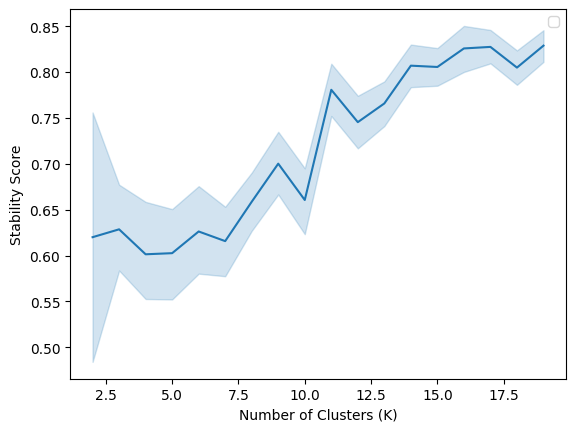

In [23]:
# Plot stability scores
import seaborn as sns
sns.lineplot(x=ks, y=stability_scores)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")
plt.legend()
plt.show()

In [ ]:
# examine the k-means clustering using different metrics; 
# - silhouette_score (best value is 1, worst value is -1)
# - calinski_harabasz_score ( larger is better )
# - davies_bouldin_score (smaller is better )
np.random.seed(0)
perf_s = {}
perf_c = {}
perf_d = {}
for k in tqdm(KS):
    model = cluster.KMeans(n_clusters=k, n_init=10)
    part = model.fit_predict(X_scaled)
    perf_s[k] = silhouette_score(X_scaled, part)
    perf_c[k] = calinski_harabasz_score(X_scaled, part)
    perf_d[k] = davies_bouldin_score(X_scaled, part)

In [ ]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=KS,
)
display(_tmp)

### DBSCAN

- Find if they are stable clusters in the data?

In [ ]:
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ari

np.random.seed(0)
KS = range(2, 11)
N_REPS = 10

ks = []
stability_scores = []

for k in tqdm(KS):
    labels = []

    for _ in range(N_REPS):
        # to generate more diversity in the results
        hdb = cluster.HDBSCAN(min_cluster_size=k)
        labels.append(hdb.fit_predict(X_scaled))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

  0%|                                                     | 0/9 [00:00<?, ?it/s]

In [ ]:
import seaborn as sns
sns.lineplot(x=ks, y=stability_scores)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")
plt.title("
plt.legend()
plt.show()

## 3. Cluster Evaluation and Interpretation

- Using external metrics, assess how well the clustering solutions match the true labels/targets (tissue of origin).
- Using internal metrics, assess the quality of the clustering solutions.
- Identify the most important genes (features) that drive the clustering results. Explain your approach and findings.
- Identify the most important genes for each tissue separately. Explain your approach and findings.